In [1]:
%matplotlib widget

# Use: pip install ipywidgets ipympl
  
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add project path
project_root = Path("..").resolve()
sys.path.append(str(project_root))

from ml_toolbox.data_loader import DataLoader, WindowConfig, WindowExtractor

In [2]:
# Load data and create windows
dataset_path = Path("../data_set")
data_loader = DataLoader(dataset_path)

# Load one sample for demo
current_data, metadata = data_loader.load_batch(
    condition='faulty_bearing', 
    load='no_load', 
    sensor_type='current', 
    apply_filter=False,
    max_workers=1
)

# Signal processing parameters
sampling_freq = 10000  # 10 kHz
cutoff_freq = 3500     # 3.5 kHz cutoff
median_window = 7      # Median filter window

num_samples = current_data[0].shape[0] 
# Create windows
window_size = num_samples # All file
overlap_ratio = 0.5
step_size = int(window_size * (1 - overlap_ratio))
window_config = WindowConfig(window_size=window_size, 
                             step_size=step_size,
                             overlap_ratio=overlap_ratio)
extractor = WindowExtractor(window_config)
windows, win_metadata = extractor.extract_windows(current_data[0], metadata[0])
    
    
print(f"Loaded signal: {current_data[0].shape}")
print(f"Created {len(windows)} windows")


INFO:ml_toolbox.data_loader.data_loader:Loading 12 files with 1 workers


INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 12 files


Loaded signal: (194449, 2)
Created 1 windows


In [3]:
import scipy.signal as signal_proc
from scipy.signal import butter, filtfilt, medfilt
import pandas as pd

def design_butterworth_filter(cutoff_freq, sampling_freq, order=4):
    """
    Design Butterworth lowpass filter
    
    Parameters:
    - cutoff_freq: cutoff frequency in Hz
    - sampling_freq: sampling frequency in Hz
    - order: filter order
    """
    nyquist = sampling_freq / 2
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_zero_phase_filter(data, b, a):
    """
    Apply zero-phase filtering using filtfilt
    """
    return filtfilt(b, a, data)

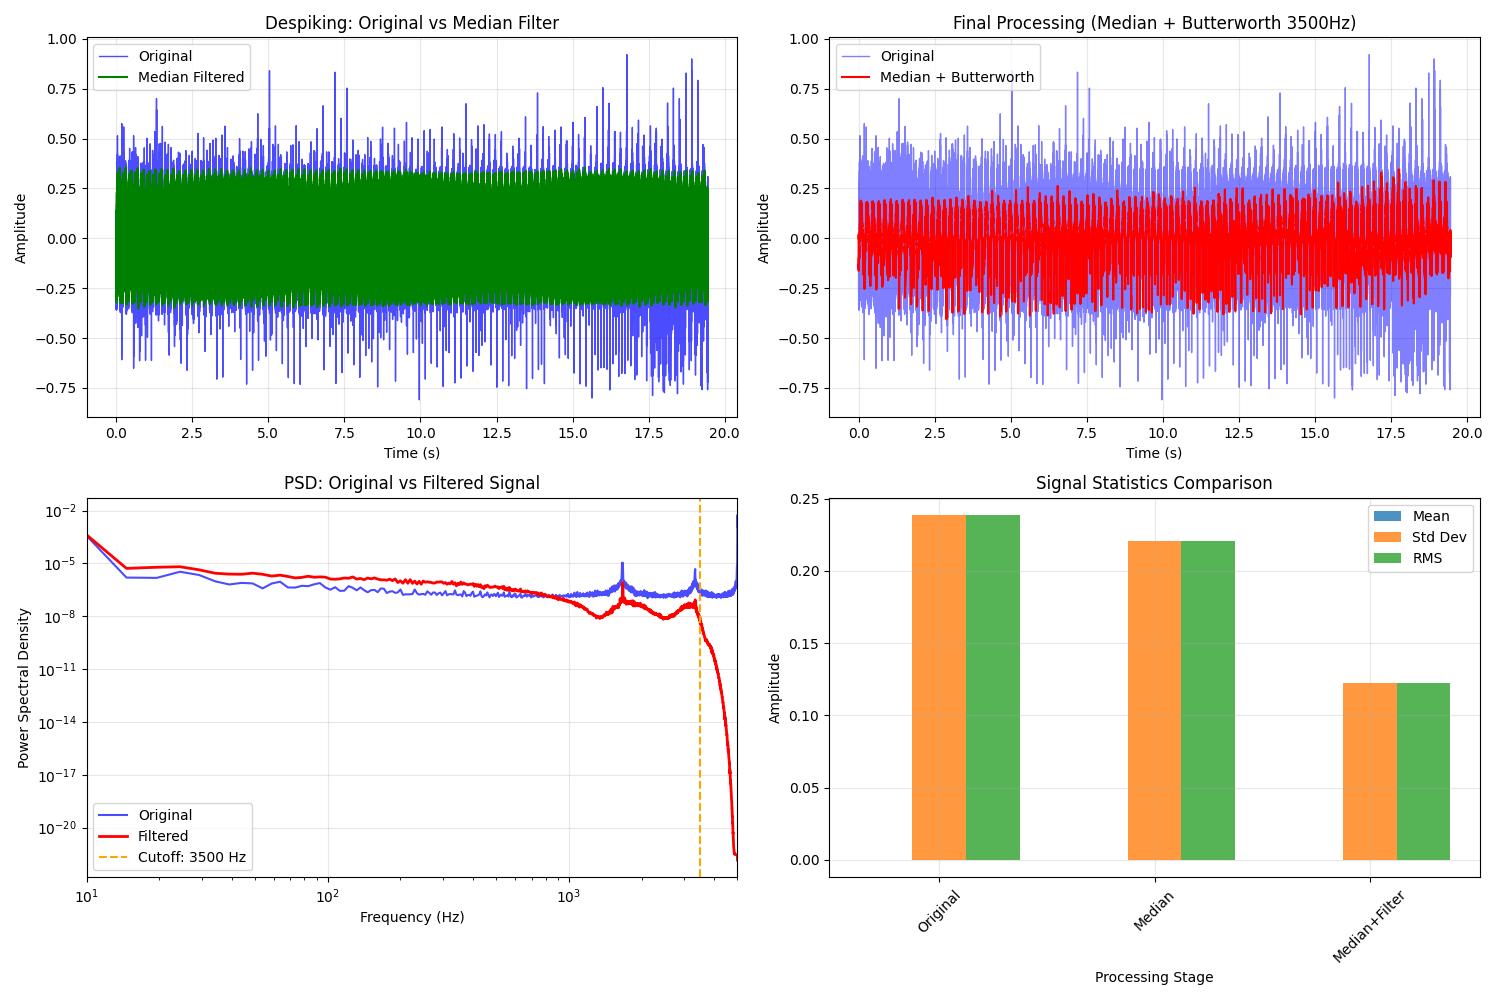

In [4]:
# Process the signal - apply despiking and filtering
window = windows[0]
original_signal = window[:, 0] if window.shape[1] > 0 else window

# Step 1: Apply median filter for despiking
median_filtered = medfilt(original_signal, kernel_size=median_window)

# Step 2: Design and apply Butterworth lowpass filter
b, a = design_butterworth_filter(cutoff_freq, sampling_freq, order=4)
filtered_signal = apply_zero_phase_filter(median_filtered, b, a)

# Create time vector
time = np.arange(len(original_signal)) / sampling_freq

# Interactive plot - compare original and processed signals
plt.ioff()  # Turn off interactive mode temporarily
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Original vs Median filtered
axes[0, 0].plot(time, original_signal, 'b-', linewidth=1, alpha=0.7, label='Original')
axes[0, 0].plot(time, median_filtered, 'g-', linewidth=1.5, label='Median Filtered')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_title('Despiking: Original vs Median Filter')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: Final processed signal (Median + Butterworth)
axes[0, 1].plot(time, original_signal, 'b-', linewidth=1, alpha=0.5, label='Original')
axes[0, 1].plot(time, filtered_signal, 'r-', linewidth=1.5, label='Median + Butterworth')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title(f'Final Processing (Median + Butterworth {cutoff_freq}Hz)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: Signal comparison in frequency domain
from scipy.signal import welch
freqs_orig, psd_orig = welch(original_signal, fs=sampling_freq, nperseg=2048)
freqs_filt, psd_filtered = welch(filtered_signal, fs=sampling_freq, nperseg=2048)

axes[1, 0].loglog(freqs_orig, psd_orig, 'b-', alpha=0.7, label='Original')
axes[1, 0].loglog(freqs_filt, psd_filtered, 'r-', linewidth=2, label='Filtered')
axes[1, 0].axvline(cutoff_freq, color='orange', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Power Spectral Density')
axes[1, 0].set_title('PSD: Original vs Filtered Signal')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_xlim(10, 5000)

# Plot 4: Signal statistics comparison
stats_data = {
    'Signal': ['Original', 'Median', 'Median+Filter'],
    'Mean': [np.mean(original_signal), np.mean(median_filtered), np.mean(filtered_signal)],
    'Std': [np.std(original_signal), np.std(median_filtered), np.std(filtered_signal)],
    'RMS': [np.sqrt(np.mean(original_signal**2)), np.sqrt(np.mean(median_filtered**2)), 
            np.sqrt(np.mean(filtered_signal**2))]
}

x_pos = np.arange(len(stats_data['Signal']))
width = 0.25
axes[1, 1].bar(x_pos - width, stats_data['Mean'], width, label='Mean', alpha=0.8)
axes[1, 1].bar(x_pos, stats_data['Std'], width, label='Std Dev', alpha=0.8)
axes[1, 1].bar(x_pos + width, stats_data['RMS'], width, label='RMS', alpha=0.8)
axes[1, 1].set_xlabel('Processing Stage')
axes[1, 1].set_ylabel('Amplitude')
axes[1, 1].set_title('Signal Statistics Comparison')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(stats_data['Signal'], rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.ion()  # Turn interactive mode back on
plt.show()

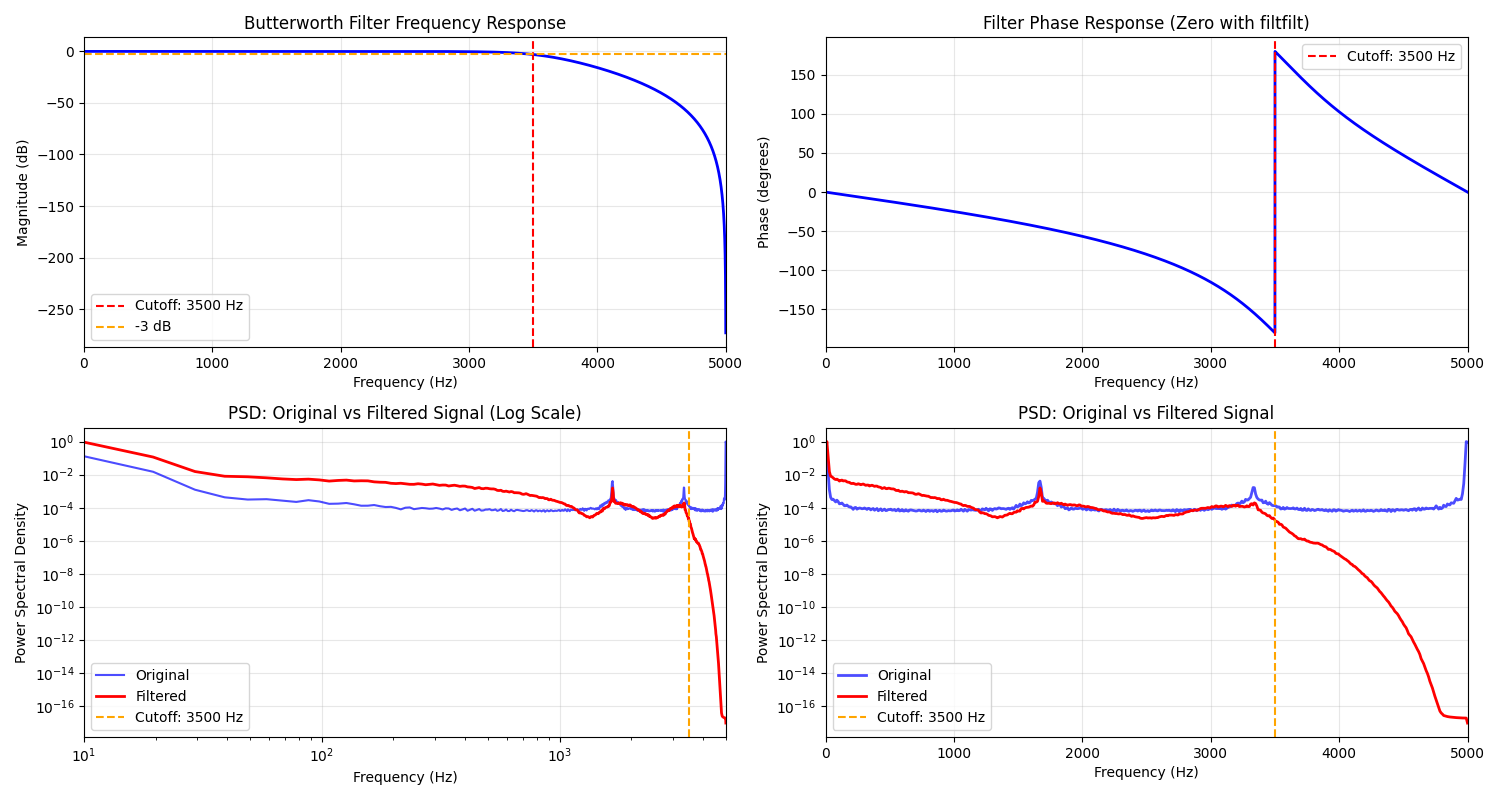


Signal Processing Summary:
Noise reduction: 48.7%


In [5]:
# Analyze filter characteristics and signal statistics
from scipy.signal import freqz

# Get filter frequency response
w, h = freqz(b, a, worN=8000, fs=sampling_freq)

# Calculate power spectral density for original and filtered signals
freqs_orig, psd_orig = signal_proc.welch(original_signal, fs=sampling_freq, nperseg=1024) 
freqs_filt, psd_filtered = signal_proc.welch(filtered_signal, fs=sampling_freq, nperseg=1024)

# Normalize to [0, 1] so thresholds are comparable
psd_orig /= np.max(psd_orig)
psd_filtered /= np.max(psd_filtered)

plt.ioff()
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Plot 1: Filter frequency response
axes[0, 0].plot(w, 20 * np.log10(abs(h)), 'b-', linewidth=2)
axes[0, 0].axvline(cutoff_freq, color='r', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[0, 0].axhline(-3, color='orange', linestyle='--', label='-3 dB')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Magnitude (dB)')
axes[0, 0].set_title('Butterworth Filter Frequency Response')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 5000)

# Plot 2: Phase response
axes[0, 1].plot(w, np.angle(h) * 180 / np.pi, 'b-', linewidth=2)
axes[0, 1].axvline(cutoff_freq, color='r', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Phase (degrees)')
axes[0, 1].set_title('Filter Phase Response (Zero with filtfilt)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 5000)

# Plot 3: Power spectral density comparison (log-log scale)
axes[1, 0].loglog(freqs_orig, psd_orig, 'b-', alpha=0.7, label='Original')
axes[1, 0].loglog(freqs_filt, psd_filtered, 'r-', linewidth=2, label='Filtered')
axes[1, 0].axvline(cutoff_freq, color='orange', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Power Spectral Density')
axes[1, 0].set_title('PSD: Original vs Filtered Signal (Log Scale)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_xlim(10, 5000)  # Start from 10 Hz to avoid log(0)

# Plot 4: Power spectral density comparison (logarithmic scale)
axes[1, 1].plot(freqs_orig, psd_orig, 'b-', alpha=0.7, label='Original', linewidth=2)
axes[1, 1].plot(freqs_filt, psd_filtered, 'r-', linewidth=2, label='Filtered')
axes[1, 1].axvline(cutoff_freq, color='orange', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Power Spectral Density')
axes[1, 1].set_title('PSD: Original vs Filtered Signal')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 5000)

plt.tight_layout()
plt.ion()
plt.show()

# Print summary statistics
print("\nSignal Processing Summary:")
print("="*50)
print(f"Noise reduction: {((np.std(original_signal) - np.std(filtered_signal))/np.std(original_signal)*100):.1f}%")

In [6]:
# Power Spectral Density Analysis
from scipy.signal import find_peaks

# Original signal analysis
noise_floor_orig = np.median(psd_orig)
peaks_orig, _ = find_peaks(psd_orig, 
                           height=noise_floor_orig*3,   # threshold above baseline
                           prominence=noise_floor_orig*2,
                           distance=5)
#peaks_orig, _ = find_peaks(psd_orig, height=1e-3, prominence=1e-3, distance=5)  
dominant_freqs_orig = freqs_orig[peaks_orig]
dominant_powers_orig = psd_orig[peaks_orig]

# Filtered signal analysis
noise_floor_filt = np.median(psd_filtered)
peaks_filt, _ = find_peaks(psd_filtered, 
                           height=noise_floor_filt*3,   # threshold above baseline
                           prominence=noise_floor_filt*2,
                           distance=5)
#peaks_filt, _ = find_peaks(psd_filtered, height=1e-3, prominence=1e-3, distance=5)
dominant_freqs_filt = freqs_filt[peaks_filt]
dominant_powers_filt = psd_filtered[peaks_filt]

print(f"1. FREQUENCY DOMAIN STATISTICS:")
print("-" * 40)
print(f"Original Signal:")
print(f"  - Total Power: {np.trapezoid(psd_orig, freqs_orig):.2e}")
print(f"  - Peak Frequency: {freqs_orig[np.argmax(psd_orig)]:.1f} Hz")
print(f"  - Peak Power: {np.max(psd_orig):.2e}")
print(f"  - Dominant frequencies: {len(dominant_freqs_orig)} peaks")
if len(dominant_freqs_orig) > 0:
    for i, (freq, power) in enumerate(zip(dominant_freqs_orig, dominant_powers_orig)):
        print(f"    Peak {i+1}: {freq:.1f} Hz (Power: {power:.2e})")

print(f"\nFiltered Signal:")
print(f"  - Total Power: {np.trapezoid(psd_filtered, freqs_filt):.2e}")
print(f"  - Peak Frequency: {freqs_filt[np.argmax(psd_filtered)]:.1f} Hz") 
print(f"  - Peak Power: {np.max(psd_filtered):.2e}")
print(f"  - Dominant frequencies: {len(dominant_freqs_filt)} peaks")
if len(dominant_freqs_filt) > 0:
    for i, (freq, power) in enumerate(zip(dominant_freqs_filt, dominant_powers_filt)):
        print(f"    Peak {i+1}: {freq:.1f} Hz (Power: {power:.2e})")

# 2. Spectral Characteristics
print(f"\n2. SPECTRAL CHARACTERISTICS:")
print("-" * 40)

# Calculate spectral centroid (weighted average frequency)
def spectral_centroid(freqs, psd):
    return np.sum(freqs * psd) / np.sum(psd)

# Calculate spectral spread (frequency dispersion)
def spectral_spread(freqs, psd, centroid):
    return np.sqrt(np.sum(((freqs - centroid) ** 2) * psd) / np.sum(psd))

centroid_orig = spectral_centroid(freqs_orig, psd_orig)
centroid_filt = spectral_centroid(freqs_filt, psd_filtered)

spread_orig = spectral_spread(freqs_orig, psd_orig, centroid_orig)
spread_filt = spectral_spread(freqs_filt, psd_filtered, centroid_filt)

print(f"Spectral Centroid (weighted avg frequency):")
print(f"  Original: {centroid_orig:.1f} Hz")
print(f"  Filtered: {centroid_filt:.1f} Hz")

print(f"\nSpectral Spread (frequency dispersion):")
print(f"  Original: {spread_orig:.1f} Hz")
print(f"  Filtered: {spread_filt:.1f} Hz")

# 3. Frequency Band Energy Distribution
print(f"\n3. FREQUENCY BAND ENERGY DISTRIBUTION:")
print("-" * 40)

# Define frequency bands
bands = {
    'Very Low (0-100 Hz)': (0, 100),
    'Low (100-500 Hz)': (100, 500),
    'Mid (500-2000 Hz)': (500, 2000),
    'High (2000-3500 Hz)': (2000, 3500)
}

for band_name, (f_low, f_high) in bands.items():
    if f_high == np.inf:
        mask_orig = freqs_orig >= f_low
        mask_filt = freqs_filt >= f_low
    else:
        mask_orig = (freqs_orig >= f_low) & (freqs_orig <= f_high)
        mask_filt = (freqs_filt >= f_low) & (freqs_filt <= f_high)
    
    if np.any(mask_orig):
        energy_orig = np.trapezoid(psd_orig[mask_orig], freqs_orig[mask_orig])
        energy_filt = np.trapezoid(psd_filtered[mask_filt], freqs_filt[mask_filt])
        
        energy_percent_orig = (energy_orig / np.trapezoid(psd_orig, freqs_orig)) * 100
        energy_percent_filt = (energy_filt / np.trapezoid(psd_filtered, freqs_filt)) * 100
        
        print(f"{band_name}:")
        print(f"  Original: {energy_percent_orig:.1f}% of total energy")
        print(f"  Filtered: {energy_percent_filt:.1f}% of total energy")
        if energy_orig > 0:
            print(f"  Retention: {(energy_filt/energy_orig)*100:.1f}%")

print("\n" + "="*60)

1. FREQUENCY DOMAIN STATISTICS:
----------------------------------------
Original Signal:
  - Total Power: 1.70e+01
  - Peak Frequency: 4990.2 Hz
  - Peak Power: 1.00e+00
  - Dominant frequencies: 4 peaks
    Peak 1: 9.8 Hz (Power: 1.41e-01)
    Peak 2: 1669.9 Hz (Power: 4.08e-03)
    Peak 3: 3330.1 Hz (Power: 1.66e-03)
    Peak 4: 4990.2 Hz (Power: 1.00e+00)

Filtered Signal:
  - Total Power: 1.38e+01
  - Peak Frequency: 9.8 Hz
  - Peak Power: 1.00e+00
  - Dominant frequencies: 8 peaks
    Peak 1: 9.8 Hz (Power: 1.00e+00)
    Peak 2: 87.9 Hz (Power: 5.35e-03)
    Peak 3: 214.8 Hz (Power: 3.02e-03)
    Peak 4: 293.0 Hz (Power: 2.72e-03)
    Peak 5: 361.3 Hz (Power: 2.29e-03)
    Peak 6: 459.0 Hz (Power: 1.65e-03)
    Peak 7: 1669.9 Hz (Power: 1.57e-03)
    Peak 8: 3339.8 Hz (Power: 1.96e-04)

2. SPECTRAL CHARACTERISTICS:
----------------------------------------
Spectral Centroid (weighted avg frequency):
  Original: 4513.1 Hz
  Filtered: 80.2 Hz

Spectral Spread (frequency dispersion):

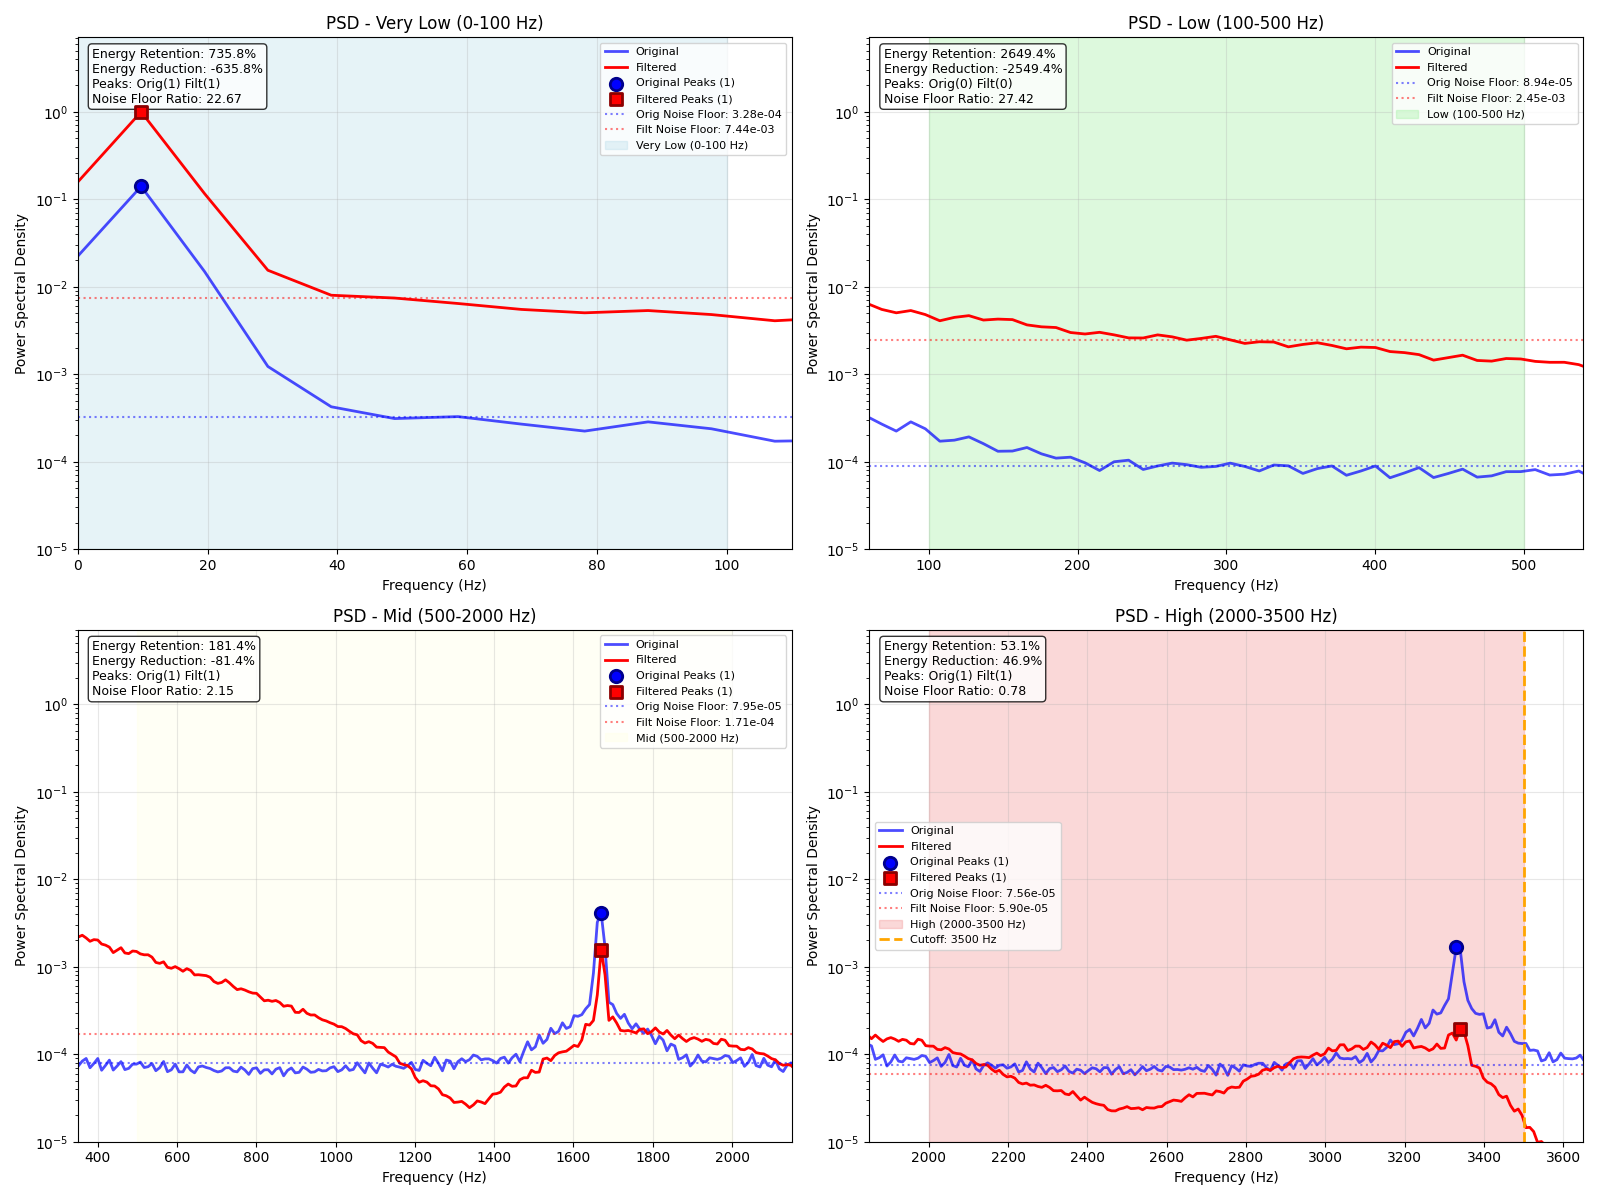


FREQUENCY BAND DETAILED PSD ANALYSIS (Band-Specific Peak Detection)

Very Low (0-100 Hz) (0-100 Hz):
--------------------------------------------------
  Band-Specific Noise Floors:
    Original: 3.28e-04
    Filtered: 7.44e-03
    Ratio (Filt/Orig): 22.669
  Original Signal:
    Highest Peak: 9.8 Hz (Power: 1.41e-01)
    Average Power: 1.65e-02
    Total Energy: 1.66e+00
    Detected Peaks (band-specific): 1
    Peak Details:
      Peak 1: 9.8 Hz (Power: 1.41e-01, Prominence: 1.18e-01)
  Filtered Signal:
    Highest Peak: 9.8 Hz (Power: 1.00e+00)
    Average Power: 1.21e-01
    Total Energy: 1.22e+01
    Detected Peaks (band-specific): 1
    Peak Details:
      Peak 1: 9.8 Hz (Power: 1.00e+00, Prominence: 8.42e-01)
  Filter Effect:
    Energy Retention: 735.8%
    Energy Reduction: -635.8%
    Average Power Reduction: -634.7%
    Peak Power Reduction: -610.9%
    Peak Count Change: 0
    Noise Floor Change: 2166.9%

Low (100-500 Hz) (100-500 Hz):
-------------------------------------

In [7]:
# PSD Plots by Individual Frequency Bands with Band-Specific Peak Detection
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# Create 4 subplots - one for each frequency band
plt.ioff()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Make it easier to iterate

colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']

for i, (band_name, (f_low, f_high)) in enumerate(bands.items()):
    ax = axes[i]
    
    # Plot PSD for both original and filtered signals
    ax.plot(freqs_orig, psd_orig, 'b-', alpha=0.7, linewidth=2, label='Original')
    ax.plot(freqs_filt, psd_filtered, 'r-', linewidth=2, label='Filtered')
    
    # Create frequency masks for this band
    mask_orig = (freqs_orig >= f_low) & (freqs_orig <= f_high)
    mask_filt = (freqs_filt >= f_low) & (freqs_filt <= f_high)
    
    # Extract band-specific data
    if np.any(mask_orig):
        band_freqs_orig = freqs_orig[mask_orig]
        band_psd_orig = psd_orig[mask_orig]
        band_freqs_filt = freqs_filt[mask_filt]
        band_psd_filt = psd_filtered[mask_filt]
        
        # Calculate band-specific noise floors (medians)
        band_noise_floor_orig = np.median(band_psd_orig)
        band_noise_floor_filt = np.median(band_psd_filt)
        
        # Find peaks using band-specific thresholds
        band_peaks_orig_idx, _ = find_peaks(band_psd_orig, 
                                           height=band_noise_floor_orig*3,   # threshold above band baseline
                                           prominence=band_noise_floor_orig*2,
                                           distance=3)  # Reduced distance for band-specific detection
        
        band_peaks_filt_idx, _ = find_peaks(band_psd_filt, 
                                           height=band_noise_floor_filt*3,   # threshold above band baseline
                                           prominence=band_noise_floor_filt*2,
                                           distance=3)
        
        # Get actual frequencies and powers of detected peaks
        band_peaks_orig = band_freqs_orig[band_peaks_orig_idx]
        band_peaks_orig_powers = band_psd_orig[band_peaks_orig_idx]
        
        band_peaks_filt = band_freqs_filt[band_peaks_filt_idx]
        band_peaks_filt_powers = band_psd_filt[band_peaks_filt_idx]
        
        # Mark peaks on the plots
        if len(band_peaks_orig) > 0:
            ax.scatter(band_peaks_orig, band_peaks_orig_powers, color='blue', 
                      s=80, marker='o', edgecolors='darkblue', linewidths=2, 
                      label=f'Original Peaks ({len(band_peaks_orig)})', zorder=5)
        
        if len(band_peaks_filt) > 0:
            ax.scatter(band_peaks_filt, band_peaks_filt_powers, color='red', 
                      s=80, marker='s', edgecolors='darkred', linewidths=2, 
                      label=f'Filtered Peaks ({len(band_peaks_filt)})', zorder=5)
        
        # Add horizontal lines showing band-specific noise floors
        ax.axhline(band_noise_floor_orig, color='blue', linestyle=':', alpha=0.5, 
                  label=f'Orig Noise Floor: {band_noise_floor_orig:.2e}')
        ax.axhline(band_noise_floor_filt, color='red', linestyle=':', alpha=0.5, 
                  label=f'Filt Noise Floor: {band_noise_floor_filt:.2e}')
    else:
        band_peaks_orig = []
        band_peaks_filt = []
    
    # Highlight the current frequency band
    ax.axvspan(f_low, f_high, alpha=0.3, color=colors[i], 
               label=f'{band_name}')
    
    # Add vertical line for cutoff frequency if it's in this band
    if f_low <= cutoff_freq <= f_high:
        ax.axvline(cutoff_freq, color='orange', linestyle='--', linewidth=2, 
                   label=f'Cutoff: {cutoff_freq} Hz')
    
    # Set limits to focus on this frequency band with some padding
    padding = (f_high - f_low) * 0.1  # 10% padding
    ax.set_xlim(max(0, f_low - padding), f_high + padding)
    
    # Set y-axis to log scale for better visualization
    ax.set_yscale('log')
    ax.set_ylim(bottom=1e-5)
    
    # Labels and formatting
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title(f'PSD - {band_name}')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)  # Smaller font due to more labels
    
    # Calculate and display energy statistics for this band
    if np.any(mask_orig):
        energy_orig = np.trapezoid(band_psd_orig, band_freqs_orig)
        energy_filt = np.trapezoid(band_psd_filt, band_freqs_filt)
        
        if energy_orig > 0:
            retention = (energy_filt / energy_orig) * 100
            reduction = (1 - energy_filt/energy_orig) * 100
            
            # Add text box with statistics including peak counts and noise floors
            stats_text = (f'Energy Retention: {retention:.1f}%\n'
                         f'Energy Reduction: {reduction:.1f}%\n'
                         f'Peaks: Orig({len(band_peaks_orig)}) Filt({len(band_peaks_filt)})\n'
                         f'Noise Floor Ratio: {band_noise_floor_filt/band_noise_floor_orig:.2f}')
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', bbox=dict(boxstyle='round', 
                   facecolor='white', alpha=0.8), fontsize=9)

plt.tight_layout()
plt.ion()
plt.show()

# Print detailed statistics for each band with band-specific peak detection
print("\n" + "="*70)
print("FREQUENCY BAND DETAILED PSD ANALYSIS (Band-Specific Peak Detection)")
print("="*70)

for band_name, (f_low, f_high) in bands.items():
    print(f"\n{band_name} ({f_low}-{f_high} Hz):")
    print("-" * 50)
    
    # Create frequency masks
    mask_orig = (freqs_orig >= f_low) & (freqs_orig <= f_high)
    mask_filt = (freqs_filt >= f_low) & (freqs_filt <= f_high)
    
    if np.any(mask_orig):
        # Extract band data
        band_freqs_orig = freqs_orig[mask_orig]
        band_psd_orig = psd_orig[mask_orig]
        band_freqs_filt = freqs_filt[mask_filt]
        band_psd_filt = psd_filtered[mask_filt]
        
        # Calculate band-specific noise floors
        band_noise_floor_orig = np.median(band_psd_orig)
        band_noise_floor_filt = np.median(band_psd_filt)
        
        # Find peaks using band-specific thresholds
        band_peaks_orig_idx, peak_props_orig = find_peaks(band_psd_orig, 
                                                          height=band_noise_floor_orig*3,
                                                          prominence=band_noise_floor_orig*2,
                                                          distance=3)
        
        band_peaks_filt_idx, peak_props_filt = find_peaks(band_psd_filt, 
                                                          height=band_noise_floor_filt*3,
                                                          prominence=band_noise_floor_filt*2,
                                                          distance=3)
        
        # Overall peak analysis (highest peak in band)
        peak_idx_orig = np.argmax(band_psd_orig)
        peak_freq_orig = band_freqs_orig[peak_idx_orig]
        peak_power_orig = band_psd_orig[peak_idx_orig]
        
        peak_idx_filt = np.argmax(band_psd_filt)
        peak_freq_filt = band_freqs_filt[peak_idx_filt]
        peak_power_filt = band_psd_filt[peak_idx_filt]
        
        # Energy analysis
        energy_orig = np.trapezoid(band_psd_orig, band_freqs_orig)
        energy_filt = np.trapezoid(band_psd_filt, band_freqs_filt)
        
        # Statistics
        avg_power_orig = np.mean(band_psd_orig)
        avg_power_filt = np.mean(band_psd_filt)
        
        print(f"  Band-Specific Noise Floors:")
        print(f"    Original: {band_noise_floor_orig:.2e}")
        print(f"    Filtered: {band_noise_floor_filt:.2e}")
        print(f"    Ratio (Filt/Orig): {band_noise_floor_filt/band_noise_floor_orig:.3f}")
        
        print(f"  Original Signal:")
        print(f"    Highest Peak: {peak_freq_orig:.1f} Hz (Power: {peak_power_orig:.2e})")
        print(f"    Average Power: {avg_power_orig:.2e}")
        print(f"    Total Energy: {energy_orig:.2e}")
        print(f"    Detected Peaks (band-specific): {len(band_peaks_orig_idx)}")
        
        if len(band_peaks_orig_idx) > 0:
            print(f"    Peak Details:")
            for j, (peak_idx, freq, power) in enumerate(zip(band_peaks_orig_idx, 
                                                           band_freqs_orig[band_peaks_orig_idx], 
                                                           band_psd_orig[band_peaks_orig_idx])):
                prominence = peak_props_orig['prominences'][j] if 'prominences' in peak_props_orig else 0
                print(f"      Peak {j+1}: {freq:.1f} Hz (Power: {power:.2e}, Prominence: {prominence:.2e})")
        
        print(f"  Filtered Signal:")
        print(f"    Highest Peak: {peak_freq_filt:.1f} Hz (Power: {peak_power_filt:.2e})")
        print(f"    Average Power: {avg_power_filt:.2e}")
        print(f"    Total Energy: {energy_filt:.2e}")
        print(f"    Detected Peaks (band-specific): {len(band_peaks_filt_idx)}")
        
        if len(band_peaks_filt_idx) > 0:
            print(f"    Peak Details:")
            for j, (peak_idx, freq, power) in enumerate(zip(band_peaks_filt_idx, 
                                                           band_freqs_filt[band_peaks_filt_idx], 
                                                           band_psd_filt[band_peaks_filt_idx])):
                prominence = peak_props_filt['prominences'][j] if 'prominences' in peak_props_filt else 0
                print(f"      Peak {j+1}: {freq:.1f} Hz (Power: {power:.2e}, Prominence: {prominence:.2e})")
        
        print(f"  Filter Effect:")
        if energy_orig > 0:
            retention = (energy_filt / energy_orig) * 100
            reduction = (1 - energy_filt/energy_orig) * 100
            print(f"    Energy Retention: {retention:.1f}%")
            print(f"    Energy Reduction: {reduction:.1f}%")
        
        if avg_power_orig > 0:
            avg_power_reduction = (1 - avg_power_filt/avg_power_orig) * 100
            print(f"    Average Power Reduction: {avg_power_reduction:.1f}%")
        
        if peak_power_orig > 0:
            peak_power_reduction = (1 - peak_power_filt/peak_power_orig) * 100
            print(f"    Peak Power Reduction: {peak_power_reduction:.1f}%")
            
        print(f"    Peak Count Change: {len(band_peaks_filt_idx) - len(band_peaks_orig_idx)}")
        print(f"    Noise Floor Change: {((band_noise_floor_filt - band_noise_floor_orig)/band_noise_floor_orig)*100:.1f}%")
    else:
        print(f"  No data in this frequency range")

print("\n" + "="*70)

In [ ]:
# Generate comprehensive PDF report for all datasets
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from scipy.signal import welch, find_peaks

def process_and_plot_all_datasets():
    """
    Process all datasets and create separate PDF files for each condition with:
    Page 1: 4 time domain plots per file:
    - Top left: Channel A unfiltered
    - Top right: Channel B unfiltered  
    - Bottom left: Channel A filtered
    - Bottom right: Channel B filtered
    
    Page 2: 4 frequency domain plots per file with peak detection:
    - Top left: Channel A PSD (Very Low & Low bands)
    - Top right: Channel A PSD (Mid & High bands)  
    - Bottom left: Channel B PSD (Very Low & Low bands)
    - Bottom right: Channel B PSD (Mid & High bands)
    """
    
    # All conditions and loads to process
    conditions = ['healthy', 'faulty bearing', 'misalignment', 'system misalignment']
    loads = ['no_load']  # Removed 'under_load' as requested
    
    # Use configuration from cell 2
    dataset_path = Path("../data_set")
    data_loader = DataLoader(dataset_path)
    
    # Store all generated PDF filenames
    generated_pdfs = []
    
    # Define frequency bands for analysis
    bands = {
        'Very Low (0-100 Hz)': (0, 100),
        'Low (100-500 Hz)': (100, 500),
        'Mid (500-2000 Hz)': (500, 2000),
        'High (2000-3500 Hz)': (2000, 3500)
    }
    
    # First, collect all data and group by frequency
    print("Loading all data and grouping by frequency...")
    frequency_groups = {}
    
    for condition in conditions:
        for load in loads:
            try:
                print(f"Loading: {condition} - {load}")
                
                # Load current data
                current_data, metadata = data_loader.load_batch(
                    condition=condition,
                    load=load,
                    sensor_type='current',
                    max_workers=1
                )
                
                if not current_data:
                    print(f"No data found for {condition} - {load}")
                    continue
                
                # Group files by frequency
                for signal_data, signal_metadata in zip(current_data, metadata):
                    freq_speed = signal_metadata.get('frequency', 'Unknown')
                    
                    if freq_speed not in frequency_groups:
                        frequency_groups[freq_speed] = []
                    
                    frequency_groups[freq_speed].append({
                        'signal_data': signal_data,
                        'signal_metadata': signal_metadata,
                        'condition': condition,
                        'load': load
                    })
                    
            except Exception as e:
                print(f"Error loading {condition} - {load}: {str(e)}")
                continue
    
    print(f"Found {len(frequency_groups)} frequency groups: {list(frequency_groups.keys())}")
    
    # Process each frequency group separately
    for freq_speed in sorted(frequency_groups.keys()):
        # Create separate PDF for each frequency
        pdf_filename = f"../frequency_{freq_speed}Hz_analysis.pdf"
        generated_pdfs.append(pdf_filename)
        
        with PdfPages(pdf_filename) as pdf:
            page_count = 0
            files_in_group = frequency_groups[freq_speed]
            
            print(f"\nProcessing frequency {freq_speed}Hz ({len(files_in_group)} files)")
            
            # Process all files for this frequency
            for file_idx, file_data in enumerate(files_in_group):
                signal_data = file_data['signal_data']
                signal_metadata = file_data['signal_metadata']
                condition = file_data['condition']
                load = file_data['load']
                
                try:
                    print(f"  Processing file {file_idx + 1}/{len(files_in_group)}: {condition} - {signal_metadata.get('filename', 'Unknown')}")
                    
                    # Create windows using same config as cell 2
                    num_samples = signal_data.shape[0]
                    window_size = num_samples  # All file
                    overlap_ratio = 0.5
                    step_size = int(window_size * (1 - overlap_ratio))
                    window_config = WindowConfig(window_size=window_size, 
                                               step_size=step_size,
                                               overlap_ratio=overlap_ratio)
                    extractor = WindowExtractor(window_config)
                    windows, win_metadata = extractor.extract_windows(signal_data, signal_metadata)
                    
                    # Process first window
                    window = windows[0]
                    
                    # Extract channels A and B
                    if window.shape[1] >= 2:
                        channel_a = window[:, 0]
                        channel_b = window[:, 1]
                    else:
                        # If only one channel, duplicate it
                        channel_a = window[:, 0] if window.shape[1] > 0 else window.flatten()
                        channel_b = channel_a.copy()
                    
                    # Apply filtering to both channels using median filter
                    # Channel A processing
                    median_filtered_a = medfilt(channel_a, kernel_size=median_window)
                    filtered_a = apply_zero_phase_filter(median_filtered_a, b, a)
                    
                    # Channel B processing  
                    median_filtered_b = medfilt(channel_b, kernel_size=median_window)
                    filtered_b = apply_zero_phase_filter(median_filtered_b, b, a)
                    
                    # Create time vector
                    time = np.arange(len(channel_a)) / sampling_freq
                    
                    # Create the 4-subplot figure for time domain
                    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
                    
                    # Plot 1: Channel A unfiltered
                    axes[0, 0].plot(time, channel_a, 'b-', linewidth=1, alpha=0.8)
                    axes[0, 0].set_title(f'Channel A - Unfiltered\n{condition.title()} - {load.replace("_", " ").title()}', 
                                        fontsize=12, fontweight='bold')
                    axes[0, 0].set_xlabel('Time (s)')
                    axes[0, 0].set_ylabel('Amplitude')
                    axes[0, 0].grid(True, alpha=0.3)
                    
                    # Plot 2: Channel B unfiltered
                    axes[0, 1].plot(time, channel_b, 'g-', linewidth=1, alpha=0.8)
                    axes[0, 1].set_title(f'Channel B - Unfiltered\n{condition.title()} - {load.replace("_", " ").title()}', 
                                        fontsize=12, fontweight='bold')
                    axes[0, 1].set_xlabel('Time (s)')
                    axes[0, 1].set_ylabel('Amplitude')
                    axes[0, 1].grid(True, alpha=0.3)
                    
                    # Plot 3: Channel A filtered (only filtered signal)
                    axes[1, 0].plot(time, filtered_a, 'r-', linewidth=1.5)
                    axes[1, 0].set_title(f'Channel A - Filtered (Median + Butterworth {cutoff_freq}Hz)', 
                                        fontsize=12, fontweight='bold')
                    axes[1, 0].set_xlabel('Time (s)')
                    axes[1, 0].set_ylabel('Amplitude')
                    axes[1, 0].grid(True, alpha=0.3)
                    
                    # Plot 4: Channel B filtered (only filtered signal)
                    axes[1, 1].plot(time, filtered_b, 'purple', linewidth=1.5)
                    axes[1, 1].set_title(f'Channel B - Filtered (Median + Butterworth {cutoff_freq}Hz)', 
                                        fontsize=12, fontweight='bold')
                    axes[1, 1].set_xlabel('Time (s)')
                    axes[1, 1].set_ylabel('Amplitude')
                    axes[1, 1].grid(True, alpha=0.3)
                    
                    # Add overall figure title with frequency speed from metadata
                    fig.suptitle(f'Time Domain Analysis: {condition.title()} - {load.replace("_", " ").title()}\n'
                               f'File {file_idx+1}/{len(files_in_group)} | Frequency Speed: {freq_speed}Hz | '
                               f'Sampling: {sampling_freq}Hz | Median kernel: {median_window}', 
                               fontsize=14, fontweight='bold', y=0.95)
                    
                    plt.tight_layout()
                    plt.subplots_adjust(top=0.88)  # Make room for suptitle
                    
                    # Save time domain page to PDF
                    pdf.savefig(fig, dpi=150, bbox_inches='tight')
                    plt.close(fig)  # Free memory
                    
                    page_count += 1
                    print(f"Page {page_count} added: Time domain - {condition} - {load} - File {file_idx+1}")
                        
                    
                    # === FREQUENCY DOMAIN ANALYSIS PAGE ===
                    
                    # Calculate PSD for both channels (original and filtered)
                    freqs_orig_a, psd_orig_a = welch(channel_a, fs=sampling_freq, nperseg=1024)
                    freqs_filt_a, psd_filt_a = welch(filtered_a, fs=sampling_freq, nperseg=1024)
                    freqs_orig_b, psd_orig_b = welch(channel_b, fs=sampling_freq, nperseg=1024)
                    freqs_filt_b, psd_filt_b = welch(filtered_b, fs=sampling_freq, nperseg=1024)
                    
                    # Normalize PSDs to [0, 1] for consistent peak detection
                    psd_orig_a_norm = psd_orig_a / np.max(psd_orig_a)
                    psd_filt_a_norm = psd_filt_a / np.max(psd_filt_a)
                    psd_orig_b_norm = psd_orig_b / np.max(psd_orig_b)
                    psd_filt_b_norm = psd_filt_b / np.max(psd_filt_b)
                    
                    # Create frequency domain figure
                    fig_freq, axes_freq = plt.subplots(2, 2, figsize=(16, 12))
                    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
                    
                    # Function to plot frequency band with peak detection
                    def plot_frequency_band(ax, freqs_orig, psd_orig, freqs_filt, psd_filt, 
                                          psd_orig_norm, psd_filt_norm, band_name, f_low, f_high, color, channel_name):
                        
                        # Plot PSD for both original and filtered signals
                        ax.plot(freqs_orig, psd_orig, 'b-', alpha=0.7, linewidth=2, label='Original')
                        ax.plot(freqs_filt, psd_filt, 'r-', linewidth=2, label='Filtered')
                        
                        # Create frequency masks for this band
                        mask_orig = (freqs_orig >= f_low) & (freqs_orig <= f_high)
                        mask_filt = (freqs_filt >= f_low) & (freqs_filt <= f_high)
                        
                        # Extract band-specific data
                        if np.any(mask_orig):
                            band_freqs_orig = freqs_orig[mask_orig]
                            band_psd_orig_norm = psd_orig_norm[mask_orig]
                            band_freqs_filt = freqs_filt[mask_filt]
                            band_psd_filt_norm = psd_filt_norm[mask_filt]
                            
                            # Calculate band-specific noise floors (medians)
                            band_noise_floor_orig = np.median(band_psd_orig_norm)
                            band_noise_floor_filt = np.median(band_psd_filt_norm)
                            
                            # Find peaks using band-specific thresholds
                            band_peaks_orig_idx, _ = find_peaks(band_psd_orig_norm, 
                                                               height=band_noise_floor_orig*3,
                                                               prominence=band_noise_floor_orig*2,
                                                               distance=3)
                            
                            band_peaks_filt_idx, _ = find_peaks(band_psd_filt_norm, 
                                                               height=band_noise_floor_filt*3,
                                                               prominence=band_noise_floor_filt*2,
                                                               distance=3)
                            
                            # Get actual frequencies and powers of detected peaks (original scale)
                            if len(band_peaks_orig_idx) > 0:
                                band_peaks_orig = band_freqs_orig[band_peaks_orig_idx]
                                band_peaks_orig_powers = psd_orig[mask_orig][band_peaks_orig_idx]
                                ax.scatter(band_peaks_orig, band_peaks_orig_powers, color='blue', 
                                          s=60, marker='o', edgecolors='darkblue', linewidths=2, 
                                          label=f'Original Peaks ({len(band_peaks_orig)})', zorder=5)
                            
                            if len(band_peaks_filt_idx) > 0:
                                band_peaks_filt = band_freqs_filt[band_peaks_filt_idx]
                                band_peaks_filt_powers = psd_filt[mask_filt][band_peaks_filt_idx]
                                ax.scatter(band_peaks_filt, band_peaks_filt_powers, color='red', 
                                          s=60, marker='s', edgecolors='darkred', linewidths=2, 
                                          label=f'Filtered Peaks ({len(band_peaks_filt)})', zorder=5)
                            
                            # Add text box with peak statistics only
                            stats_text = f'Peaks: Orig({len(band_peaks_orig_idx)}) Filt({len(band_peaks_filt_idx)})'
                            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                                   verticalalignment='top', bbox=dict(boxstyle='round', 
                                   facecolor='white', alpha=0.8), fontsize=9)
                        
                        # Highlight the current frequency band
                        ax.axvspan(f_low, f_high, alpha=0.3, color=color, label=f'{band_name}')
                        
                        # Add vertical line for cutoff frequency if it's in this band
                        if f_low <= cutoff_freq <= f_high:
                            ax.axvline(cutoff_freq, color='orange', linestyle='--', linewidth=2, 
                                       label=f'Cutoff: {cutoff_freq} Hz')
                        
                        # Set limits to focus on this frequency band with some padding
                        padding = (f_high - f_low) * 0.1
                        ax.set_xlim(max(0, f_low - padding), f_high + padding)
                        
                        # Set y-axis to log scale for better visualization
                        ax.set_yscale('log')
                        ax.set_ylim(bottom=1e-10)
                        
                        # Labels and formatting
                        ax.set_xlabel('Frequency (Hz)')
                        ax.set_ylabel('Power Spectral Density')
                        ax.set_title(f'{channel_name} PSD - {band_name}', fontsize=11, fontweight='bold')
                        ax.grid(True, alpha=0.3)
                        ax.legend(fontsize=8)
                    
                    # Plot frequency bands for Channel A
                    # Top left: Channel A - Very Low & Low bands combined
                    plot_frequency_band(axes_freq[0, 0], freqs_orig_a, psd_orig_a, freqs_filt_a, psd_filt_a,
                                      psd_orig_a_norm, psd_filt_a_norm, "Very Low & Low", 0, 500, 'lightblue', 'Channel A')
                    
                    # Top right: Channel A - Mid & High bands combined  
                    plot_frequency_band(axes_freq[0, 1], freqs_orig_a, psd_orig_a, freqs_filt_a, psd_filt_a,
                                      psd_orig_a_norm, psd_filt_a_norm, "Mid & High", 500, 3500, 'lightgreen', 'Channel A')
                    
                    # Bottom left: Channel B - Very Low & Low bands combined
                    plot_frequency_band(axes_freq[1, 0], freqs_orig_b, psd_orig_b, freqs_filt_b, psd_filt_b,
                                      psd_orig_b_norm, psd_filt_b_norm, "Very Low & Low", 0, 500, 'lightyellow', 'Channel B')
                    
                    # Bottom right: Channel B - Mid & High bands combined
                    plot_frequency_band(axes_freq[1, 1], freqs_orig_b, psd_orig_b, freqs_filt_b, psd_filt_b,
                                      psd_orig_b_norm, psd_filt_b_norm, "Mid & High", 500, 3500, 'lightcoral', 'Channel B')
                    
                    # Add overall figure title for frequency domain
                    fig_freq.suptitle(f'Frequency Domain Analysis: {condition.title()} - {load.replace("_", " ").title()}\n'
                                    f'File {file_idx+1}/{len(files_in_group)} | Frequency Speed: {freq_speed}Hz | '
                                    f'Peak Detection with Band-Specific Thresholds', 
                                    fontsize=14, fontweight='bold', y=0.95)
                    
                    plt.tight_layout()
                    plt.subplots_adjust(top=0.88)  # Make room for suptitle
                    
                    # Save frequency domain page to PDF
                    pdf.savefig(fig_freq, dpi=150, bbox_inches='tight')
                    plt.close(fig_freq)  # Free memory
                    
                    page_count += 1
                    print(f"Page {page_count} added: Frequency domain - {condition} - {load} - File {file_idx+1}")
                except Exception as e:
                    print(f"Error processing file {file_idx+1} in {freq_speed}Hz group: {str(e)}")
                    continue
            
            print(f"\nPDF report generated: {pdf_filename}")
            print(f"Total pages: {page_count}")
    
    print(f"\nAll PDF reports generated:")
    for pdf_file in generated_pdfs:
        print(f"  - {pdf_file}")
    return generated_pdfs

# Execute the analysis
pdf_files = process_and_plot_all_datasets()

IndentationError: unexpected indent (1473517210.py, line 118)